In [1]:
# Import libraries
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, recall_score
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout
from keras.optimizers import SGD
import pandas as pd

2024-11-25 16:09:34.982279: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-25 16:09:34.999166: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732547375.017694 2159356 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732547375.023333 2159356 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-25 16:09:35.042500: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
import os
import tensorflow as tf

# Forceer geen GPU gebruik
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
tf.config.set_visible_devices([], 'GPU')

2024-11-25 16:09:36.513450: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-11-25 16:09:36.513490: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:137] retrieving CUDA diagnostic information for host: janssenp2.mads-han.src.surf-hosted.nl
2024-11-25 16:09:36.513495: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:144] hostname: janssenp2.mads-han.src.surf-hosted.nl
2024-11-25 16:09:36.513650: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:168] libcuda reported version is: 535.183.1
2024-11-25 16:09:36.513668: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:172] kernel reported version is: 535.183.1
2024-11-25 16:09:36.513672: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:259] kernel version seems to match DSO: 535.183.1


In [25]:
# Stel de padlocatie in van het Parquet-bestand
path_train =  '../../Mads_hackathon_dreamteam/data/raw/heart_big_train.parq'
# path_valid = '../../Mads_hackathon_dreamteam/data/raw/heart_big_valid.parq'
path_valid = '../../Mads_hackathon_dreamteam/data/raw/heart_big_test.parq'

# path_test = '../../Mads_hackathon_dreamteam/data/raw/heart_big_test.parq'

#import dataframe
df_valid = pd.read_parquet(path_valid)
df_train = pd.read_parquet(path_train)
# df_test = pd.read_parquet(path_test)

In [26]:
# Features (X) en target (y) splitsen
X_train = df_train.iloc[:, :-1].values  # Alle kolommen behalve 'target'
y_train = df_train.iloc[:, -1].values  # Laatste kolom is 'target'

X_valid = df_valid.iloc[:, :-1].values
y_valid = df_valid.iloc[:, -1].values

# Schalen van features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

# Klassenbalans corrigeren met SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Functie om TP-rate per klasse te berekenen
def calculate_tp_rate(y_true, y_pred):
    class_recall = recall_score(y_true, y_pred, average=None)  # Recall per klasse
    return {f"Class {i}": recall for i, recall in enumerate(class_recall)}

# Evaluatie functie
def evaluate_model(model, X_valid, y_valid):
    y_pred = model.predict(X_valid)
    accuracy = accuracy_score(y_valid, y_pred)
    tp_rates = calculate_tp_rate(y_valid, y_pred)
    print(f"Accuracy: {accuracy}")
    print("TP Rates per class:", tp_rates)
    print("Classification Report:\n", classification_report(y_valid, y_pred))


In [14]:

# Zorg ervoor dat de data gebalanceerd is
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Neural Network Model met Dropout en EarlyStopping
print("\n--- Neural Network ---")
nn_model = Sequential()

# Eerste verborgen laag met Dropout
nn_model.add(Dense(128, activation='relu', input_shape=(X_train_balanced.shape[1],)))
nn_model.add(Dropout(0.3))  # Dropout laag om overfitting te voorkomen
# Tweede verborgen laag
nn_model.add(Dense(128, activation='relu'))
nn_model.add(Dropout(0.3))  # Dropout laag
# Derde verborgen laag
nn_model.add(Dense(64, activation='relu'))
nn_model.add(Dropout(0.3))  # Dropout laag
# Vierde verborgen laag
nn_model.add(Dense(32, activation='relu'))
nn_model.add(Dropout(0.3))  # Dropout laag

# Output laag voor 5 klassen
nn_model.add(Dense(5, activation='softmax'))

# Compileer het model
nn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# nn_model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Early stopping om overfitting te voorkomen
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train het model
nn_model.fit(X_train_balanced, y_train_balanced, epochs=50, batch_size=32, verbose=1, 
             validation_data=(X_valid, y_valid), callbacks=[early_stopping])

# Evaluatie van het Neural Network
y_pred_nn = nn_model.predict(X_valid).argmax(axis=1)

# Bereken accuracy en TP rate per klasse
accuracy_nn = accuracy_score(y_valid, y_pred_nn)
tp_rates_nn = calculate_tp_rate(y_valid, y_pred_nn)

# Print de resultaten
print(f"Neural Network Accuracy: {accuracy_nn}")
print("TP Rates per class:", tp_rates_nn)
print("Classification Report:\n", classification_report(y_valid, y_pred_nn))




--- Neural Network ---


/home/pjanssen/Mads_hackathon_dreamteam/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
11324/11324 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.7999 - loss: 0.5399 - val_accuracy: 0.8922 - val_loss: 0.2660
Epoch 2/50
11324/11324 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.9211 - loss: 0.2303 - val_accuracy: 0.9354 - val_loss: 0.1983
Epoch 3/50
11324/11324 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9384 - loss: 0.1877 - val_accuracy: 0.9353 - val_loss: 0.1969
Epoch 4/50
11324/11324 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.9447 - loss: 0.1670 - val_accuracy: 0.9321 - val_loss: 0.1934
Epoch 5/50
11324/11324 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.9498 - loss: 0.1549 - val_accuracy: 0.9503 - val_loss: 0.1610
Epoch 6/50
11324/11324 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - accuracy: 0.9529 - loss: 0.1459 - val_accuracy: 0.9545 - val_loss: 0.1424
Epoch 7/50
11324/11324 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9558 - loss: 0.1389 - val_accuracy: 0.9462 - val_loss: 0.1657
Epoch 8/50
11324/11324 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 

In [27]:
# Evaluatie van het Neural Network
y_pred_nn = nn_model.predict(X_valid).argmax(axis=1)

# Bereken accuracy en TP rate per klasse
accuracy_nn = accuracy_score(y_valid, y_pred_nn)
tp_rates_nn = calculate_tp_rate(y_valid, y_pred_nn)

# Print de resultaten
print(f"Neural Network Accuracy: {accuracy_nn}")
print("TP Rates per class:", tp_rates_nn)
print("Classification Report:\n", classification_report(y_valid, y_pred_nn))

343/343 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Neural Network Accuracy: 0.9510323405810341
TP Rates per class: {'Class 0': np.float64(0.9544099790263826), 'Class 1': np.float64(0.7877697841726619), 'Class 2': np.float64(0.9337016574585635), 'Class 3': np.float64(0.9135802469135802), 'Class 4': np.float64(0.9888059701492538)}
Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.95      0.97      9059
         1.0       0.44      0.79      0.57       278
         2.0       0.91      0.93      0.92       724
         3.0       0.43      0.91      0.59        81
         4.0       0.98      0.99      0.98       804

    accuracy                           0.95     10946
   macro avg       0.75      0.92      0.81     10946
weighted avg       0.97      0.95      0.96     10946



In [28]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Predict class probabilities
y_pred_probs = nn_model.predict(X_valid)

# Convert probabilities to predicted classes
y_pred_classes = y_pred_probs.argmax(axis=1)  # Select class with the highest probability


343/343 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [29]:
# Compute the confusion matrix
cm = confusion_matrix(y_valid, y_pred_classes, labels=[0, 1, 2, 3, 4])

# Normalize confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

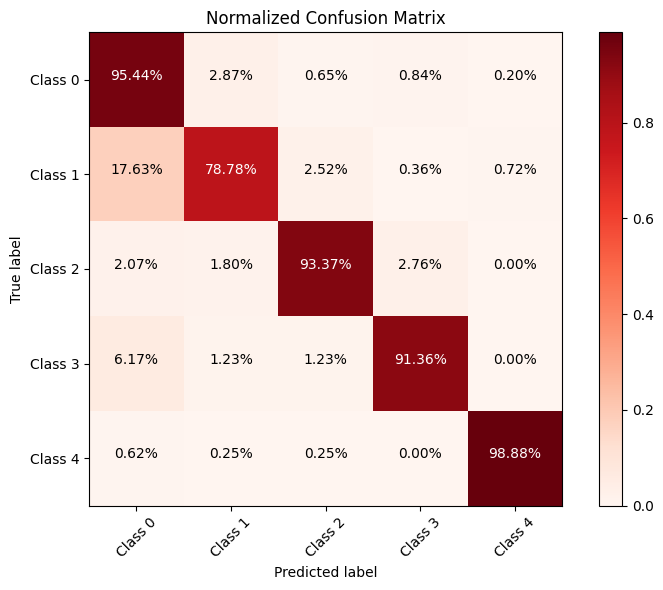

In [30]:
def plot_confusion_matrix_normalized(cm, class_names):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.get_cmap('Reds'))
    plt.title("Normalized Confusion Matrix")
    plt.colorbar()

    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Add percentages as text annotations
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, f"{cm[i, j]:.2%}",
                 horizontalalignment="center",
                 color="white" if cm[i, j] > 0.5 else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Class names for the confusion matrix
class_names = [f"Class {i}" for i in range(5)]

# Plot the normalized confusion matrix
plot_confusion_matrix_normalized(cm_normalized, class_names)
plt.show()
